# 自動特徴量選択

高次元データセットの場合，最も有用な特徴量だけを残して残りを捨て特徴量を減らすと，モデルが単純になり汎化性能が向上する．

よい特徴量を調べるためには

- 単変量統計
- モデルベース選択
- 反復選択

の三つがある．これらは教師あり手法であり，特徴量選択時には訓練セットだけを用いて行う必要がある．

## 単変量統計

単変量統計では，個々の特徴量とターゲットの間に統計的に顕著な関係があるかどうかを計算する．そして最も高い確信度で関連している特徴量が選択される．クラス分類の場合は`分散分析`(ANOVA)と知られている．この方法の特性は`単変量`であることであり，他の特徴量と組み合わさって意味を成すような特徴量は捨てられてしまう．

In [1]:
import mglearn
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import load_breast_cancer
from sklearn.feature_selection import SelectPercentile
from sklearn.model_selection import train_test_split

cancer = load_breast_cancer()

rng = np.random.RandomState(42)
noise = rng.normal(size=(len(cancer.data), 50))

# ノイズを加える
X_w_noise = np.hstack([cancer.data, noise])

X_train, X_test, y_train, y_test = train_test_split(
    X_w_noise, cancer.target, random_state=0, test_size=.5)

select = SelectPercentile(percentile=50)
select.fit(X_train, y_train)

X_train_selected = select.transform(X_train)

print("X_train.shape: {}".format(X_train.shape))
print("X_train_selected.shape: {}".format(X_train_selected.shape))

X_train.shape: (284, 80)
X_train_selected.shape: (284, 40)


[ True  True  True  True  True  True  True  True  True False  True False
  True  True  True  True  True  True False False  True  True  True  True
  True  True  True  True  True  True False False False  True False  True
 False False  True False False False False  True False False  True False
 False  True False  True False False False False False False  True False
  True False False False False  True False  True False False False False
  True  True False  True False False False False]


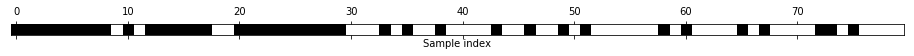

In [4]:
mask = select.get_support()
print(mask)

plt.matshow(mask.reshape(1, -1), cmap='gray_r')
plt.xlabel("Sample index")
plt.yticks(())
plt.show()

In [6]:
from sklearn.linear_model import LogisticRegression

X_test_selected = select.transform(X_test)

lr = LogisticRegression()
lr.fit(X_train, y_train)
print("Score with all features: {:.3f}".format(lr.score(X_test, y_test)))
lr.fit(X_train_selected, y_train)
print("Score with only selected features: {:.3f}".format(
    lr.score(X_test_selected, y_test)))

Score with all features: 0.930
Score with only selected features: 0.940


## モデルベース特徴量

モデルベース特徴量洗濯は，教師あり学習モデルを用いて個々の特徴量の重要性を判断し，重要なものだけを残す手法である．
単変量選択の場合とは対して，モデルベースの選択は，全ての特徴量を同時に考慮するので変数間の相互作用を捉えることが出来る

In [8]:
from sklearn.feature_selection import SelectFromModel
from sklearn.ensemble import RandomForestClassifier
select = SelectFromModel(
    RandomForestClassifier(n_estimators=100, random_state=42),
    threshold="median")

SelectFromModelクラスは教師あり学習モデルで得られた特徴量の重要性が，指定したスレッショルドよりも大きい特徴量だけを選択する．

In [9]:
select.fit(X_train, y_train)
X_train_l1 = select.transform(X_train)
print("X_train.shape: {}".format(X_train.shape))
print("X_train_l1.shape: {}".format(X_train_l1.shape))

X_train.shape: (284, 80)
X_train_l1.shape: (284, 40)


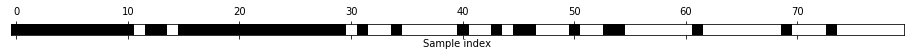

In [12]:
mask = select.get_support()
# 黒が真， 白が偽
plt.matshow(mask.reshape(1, -1), cmap='gray_r')
plt.xlabel("Sample index")
plt.yticks(())
plt.show()

In [13]:
X_test_l1 = select.transform(X_test)
score = LogisticRegression().fit(X_train_l1, y_train).score(X_test_l1, y_test)
print("Test score: {:.3f}".format(score))

Test score: 0.951


### 反復特徴量選択

- 単変量統計
    - モデルを全く使わない
- モデルベース選択
    - モデルを一つ使う
- 反復特徴量選択
    - 異なる特徴量を用いた一連のモデルを作る
    
反復特徴量では全く特徴量を使わないところから，ある基準が満たされるところまで特徴量を一つずつ加えていく方法と，全ての特徴量を使う状態から一つずつ取り除いていく方法の2つの方法がある．この方法の一つが`再帰的特徴量削減`(PFE)である．この方法は全ての特徴量から開始してモデルを作り，そのモデルで最も重要度が低い特徴量を削除する．

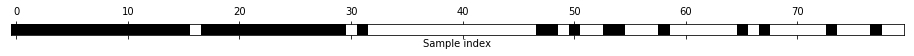

In [14]:
from sklearn.feature_selection import RFE
select = RFE(RandomForestClassifier(n_estimators=100, random_state=42),
             n_features_to_select=40)

select.fit(X_train, y_train)

mask = select.get_support()
plt.matshow(mask.reshape(1, -1), cmap='gray_r')
plt.xlabel("Sample index")
plt.yticks(())
plt.show()

In [15]:
X_train_rfe = select.transform(X_train)
X_test_rfe = select.transform(X_test)

score = LogisticRegression().fit(X_train_rfe, y_train).score(X_test_rfe, y_test)
print("Test score: {:.3f}".format(score))

Test score: 0.951


In [16]:
print("Test score: {:.3f}".format(select.score(X_test, y_test)))

Test score: 0.951
